In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
import time

# --- 1. Definición de la Clase de Dataset ---

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# --- 2. Configuración del Modelo ---

def get_resnet_model(num_classes):
    # Cargar un modelo ResNet-50 pre-entrenado
    model = models.resnet50(weights='DEFAULT')

    # Congelar los parámetros de las capas pre-entrenadas para no modificarlas
    for param in model.parameters():
        param.requires_grad = False

    # Reemplazar la última capa de clasificación para que se ajuste a nuestras clases
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model

# --- 3. Bucle de Entrenamiento ---

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Solo entrenar la última capa

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Evaluación en el set de validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f'Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, Precisión de Validación: {accuracy:.2f}%')

    print('Entrenamiento completado.')

# --- Configuración principal y ejecución ---

if __name__ == '__main__':
    # Asegúrate de que tus directorios de datos tengan esta estructura:
    # /content/drive/MyDrive/EnfermedadesCacao/train/Fito
    # /content/drive/MyDrive/EnfermedadesCacao/train/Monilia
    # /content/drive/MyDrive/EnfermedadesCacao/train/Sana
    # /content/drive/MyDrive/EnfermedadesCacao/val/Fito
    # /content/drive/MyDrive/EnfermedadesCacao/val/Monilia
    # /content/drive/MyDrive/EnfermedadesCacao/val/Sana

    data_root = '/content/drive/MyDrive/EnfermedadesCacao'
    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')
    num_classes = 3  # Fito, Monilia, Sana

    # Transformaciones de datos
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Crear los datasets y dataloaders
    train_dataset = ImageClassificationDataset(root_dir=train_dir, transform=image_transforms)
    val_dataset = ImageClassificationDataset(root_dir=val_dir, transform=image_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Inicializar el modelo y el dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_resnet_model(num_classes)

    # Entrenar el modelo
    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

    # Opcional: Guardar el modelo entrenado
    torch.save(model.state_dict(), 'resnet50_cocoa_pests.pth')
    print("Modelo guardado como resnet50_cocoa_pests.pth")

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/EnfermedadesCacao/train/labels.cache'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
import time

# --- 1. Definición de la Clase de Dataset (CORREGIDA) ---

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Filtrar solo los directorios que representan las clases
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# --- 2. Configuración del Modelo ---

def get_resnet_model(num_classes):
    model = models.resnet50(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# --- 3. Bucle de Entrenamiento ---

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f'Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, Precisión de Validación: {accuracy:.2f}%')

    print('Entrenamiento completado.')

# --- Configuración principal y ejecución ---

if __name__ == '__main__':
    data_root = '/content/drive/MyDrive/EnfermedadesCacao'
    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')
    num_classes = 3  # Fito, Monilia, Sana

    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageClassificationDataset(root_dir=train_dir, transform=image_transforms)
    val_dataset = ImageClassificationDataset(root_dir=val_dir, transform=image_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_resnet_model(num_classes)

    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

    torch.save(model.state_dict(), 'resnet50_cocoa_pests.pth')
    print("Modelo guardado como resnet50_cocoa_pests.pth")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipython-input-4147141329.py", line 32, in __getitem__
    image = Image.open(img_path).convert('RGB')
            ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3580, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/EnfermedadesCacao/train/labels/Monilia59.txt'


###Correcion del código para mantener la estructura de los otros modelos y solo leer imagenes

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image, UnidentifiedImageError
import os
import time

# --- 1. Definición de la Clase de Dataset (CORREGIDA) ---

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Filtrar solo los directorios que representan las clases
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []

        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                # Solo procesar si el archivo tiene una extensión de imagen común
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))
                # Ignorar cualquier otro archivo, como .txt

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# --- 2. Configuración del Modelo ---

def get_resnet_model(num_classes):
    model = models.resnet50(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# --- 3. Bucle de Entrenamiento ---

def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total

        print(f'Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, Precisión de Validación: {accuracy:.2f}%')

    print('Entrenamiento completado.')

# --- Configuración principal y ejecución ---

if __name__ == '__main__':
    data_root = '/content/drive/MyDrive/EnfermedadesCacao'
    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')
    num_classes = 3

    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageClassificationDataset(root_dir=train_dir, transform=image_transforms)
    val_dataset = ImageClassificationDataset(root_dir=val_dir, transform=image_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_resnet_model(num_classes)

    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

    torch.save(model.state_dict(), 'resnet50_cocoa_pests.pth')
    print("Modelo guardado como resnet50_cocoa_pests.pth")

Época [1/10], Pérdida: 0.5459, Precisión de Validación: 100.00%
Época [2/10], Pérdida: 0.0948, Precisión de Validación: 100.00%
Época [3/10], Pérdida: 0.0253, Precisión de Validación: 100.00%
Época [4/10], Pérdida: 0.0127, Precisión de Validación: 100.00%
Época [5/10], Pérdida: 0.0079, Precisión de Validación: 100.00%
Época [6/10], Pérdida: 0.0054, Precisión de Validación: 100.00%
Época [7/10], Pérdida: 0.0060, Precisión de Validación: 100.00%
Época [8/10], Pérdida: 0.0075, Precisión de Validación: 100.00%
Época [9/10], Pérdida: 0.0055, Precisión de Validación: 100.00%
Época [10/10], Pérdida: 0.0046, Precisión de Validación: 100.00%
Entrenamiento completado.
Modelo guardado como resnet50_cocoa_pests.pth


###Inclusion de metricas para valorar el modelo

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Época [1/10], Pérdida: 0.5894, Precisión de Validación: 100.00%
Época [2/10], Pérdida: 0.0748, Precisión de Validación: 100.00%
Época [3/10], Pérdida: 0.0244, Precisión de Validación: 100.00%
Época [4/10], Pérdida: 0.0156, Precisión de Validación: 100.00%
Época [5/10], Pérdida: 0.0100, Precisión de Validación: 100.00%
Época [6/10], Pérdida: 0.0063, Precisión de Validación: 100.00%
Época [7/10], Pérdida: 0.0053, Precisión de Validación: 100.00%
Época [8/10], Pérdida: 0.0059, Precisión de Validación: 100.00%
Época [9/10], Pérdida: 0.0046, Precisión de Validación: 100.00%
Época [10/10], Pérdida: 0.0048, Precisión de Validación: 100.00%
Entrenamiento completado.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


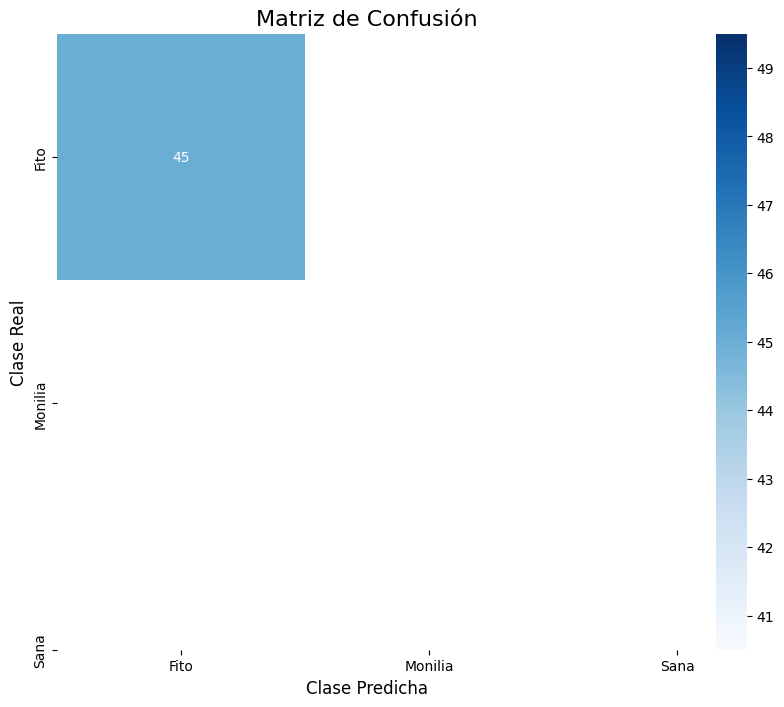


--- Métricas por Clase ---
Clase: Fito
  Precisión: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
Clase: Monilia


IndexError: index 1 is out of bounds for axis 0 with size 1

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# --- 1. Definición de la Clase de Dataset (sin cambios) ---
class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# --- 2. Configuración del Modelo (sin cambios) ---
def get_resnet_model(num_classes):
    model = models.resnet50(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# --- 3. Bucle de Entrenamiento (sin cambios) ---
def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)

        # Evaluación en el set de validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Época [{epoch+1}/{num_epochs}], Pérdida: {epoch_loss:.4f}, Precisión de Validación: {accuracy:.2f}%')
    print('Entrenamiento completado.')

# --- 4. Nueva Función para Evaluación de Métricas y Gráficas ---
def evaluate_model(model, val_loader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Generar y mostrar la Matriz de Confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión', fontsize=16)
    plt.ylabel('Clase Real', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    plt.show()

    # Calcular y mostrar las métricas de Precisión, Recall y F1-Score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

    print("\n--- Métricas por Clase ---")
    for i, name in enumerate(class_names):
        print(f"Clase: {name}")
        print(f"  Precisión: {precision[i]:.4f}")
        print(f"  Recall:    {recall[i]:.4f}")
        print(f"  F1-Score:  {f1_score[i]:.4f}")

    # Calcular métricas globales (promedio)
    avg_precision = precision.mean()
    avg_recall = recall.mean()
    avg_f1 = f1_score.mean()

    print("\n--- Métricas Globales (Promedio) ---")
    print(f"Precisión Promedio: {avg_precision:.4f}")
    print(f"Recall Promedio:    {avg_recall:.4f}")
    print(f"F1-Score Promedio:  {avg_f1:.4f}")

# --- Configuración principal y ejecución ---
if __name__ == '__main__':
    data_root = '/content/drive/MyDrive/EnfermedadesCacao'
    train_dir = os.path.join(data_root, 'train')
    val_dir = os.path.join(data_root, 'val')
    class_names = ['Fito', 'Monilia', 'Sana']
    num_classes = len(class_names)

    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageClassificationDataset(root_dir=train_dir, transform=image_transforms)
    val_dataset = ImageClassificationDataset(root_dir=val_dir, transform=image_transforms)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_resnet_model(num_classes)

    # Entrenar el modelo
    train_model(model, train_loader, val_loader, num_epochs=10, device=device)

    # Evaluar y graficar los resultados
    evaluate_model(model, val_loader, class_names, device)
